SARIMA
==========================

## Initial Fit SARIMA model
For the initial fit of the SARIMA model, we will use p = 1 and P = 0, as suggested by our PACF test. We will use d = 1, given that our ADF test indicated stationarity. We will maintain D = 1 to account for the clear seasonal patterns that recur annually. For q and Q we will have q = 0 to start with a more simple model, but lets keep Q = 1 since we have more seasonal variables in our data. Additionally, to circumvent an error from the SARIMAX function, I have included some initial parameters.

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Read the last 5 years of weather data from the CSV file
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')
df.index.freq = 'W-SUN'
last_5_years_data = df['Temperature_Max']  # Assuming you want to drop NA values

# Set initial SARIMA parameters based on ACF and PACF
p, d, q = 1, 0, 0  # Non-seasonal parameters
P, D, Q, S = 0, 1, 1, 52  # Seasonal parameters

# Manually set initial parameters
initial_parameters = [0.5,  # AR term
                      0.3,  # Seasonal MA term
                      1.0]  # Variance of the error term

# Fit the SARIMA model
model = SARIMAX(last_5_years_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit(start_params=initial_parameters, disp=False)

# Show the model summary
print(results.summary())

In [ ]:
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Temperature_Max   No. Observations:                  261
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood                -666.021
Date:                              Tue, 31 Oct 2023   AIC                           1338.042
Time:                                      16:06:25   BIC                           1348.069
Sample:                                  01-07-2018   HQIC                          1342.096
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5746      0.049     11.734      0.000       0.479       0.671
ma.S.L52      -0.9968     14.720     -0.068      0.946     -29.847      27.853
sigma2        22.9948    337.392      0.068      0.946    -638.281     684.271
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                15.79
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.21
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

It seems that Q might not be significant, as indicated by our very low z-value of -0.068 and a very high p-value of 0.946.. Furthermore, our Jarque-Bera test indicates that our residuals are not normally distributed. I experimented with changing the Q value to 0 but it did not give a better model. Let's try a thorough grid search to see if its parameters yield better results. We can examine the residuals afterward and adjust any parameters we deem necessary.

## Grid test
The grid test works by systematically going through multiple combinations of parameters, cross-validating as it goes to determine which set gives the best performance. 

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [ ]:
# Read the last 5 years of weather data from the CSV file
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')
df.index.freq = 'W-SUN'

# Focus on the 'Temperature_Max' column
last_5_years_data = df['Temperature_Max']

# Create a validation set
train = last_5_years_data[:-52]
test = last_5_years_data[-52:]

# Align the exog_data with the train and test sets
exog_train = df['Temperature_Min'][:-52]
exog_test = df['Temperature_Min'][-52:]

# Parameter grid for SARIMA model
p_values = [0, 1]
d_values = [0, 1]
q_values = [0, 1]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
S_values = [52]

best_score = float('inf')

# Grid Search
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for S in S_values:
                            try:
                                # model = sm.tsa.statespace.SARIMAX(train, exog=exog_train, order=(p,d,q), seasonal_order=(P,D,Q,S))
                                model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S))
                                fit_model = model.fit(disp=False)
                                # predictions = fit_model.get_forecast(steps=len(test), exog=exog_test).predicted_mean
                                predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1)
                                mse = mean_squared_error(test, predictions)
                                if mse < best_score:
                                    best_score = mse
                                    best_params = ((p,d,q), (P,D,Q,S))
                            except:
                                continue

print('Best MSE:', best_score)
print('Best Params:', best_params)

Best MSE: 35.05673708499157
Best Params: ((1, 1, 0), (0, 1, 1, 52))

## Re-fitting the Sarima model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from math import sqrt

In [ ]:
# Read the last 5 years of weather data from the CSV file
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')
df.index.freq = 'W-SUN'

# Set initial SARIMA parameters based Grid Test
best_params_5y = (1, 1, 0)
best_seasonal_params_5y = (0, 1, 1, 52)

# Create a validation set
train = df['Temperature_Max'][:-52]
test = df['Temperature_Max'][-52:]

# Manually set initial parameters
initial_parameters = [0.5,  # AR term
                      0.3,  # Seasonal MA term
                      1.0]  # Variance of the error term

# Refit the model on the training set and forecast the validation set
best_model_refit = SARIMAX(train,
                           order=best_params_5y,
                           seasonal_order=best_seasonal_params_5y)
best_model_refit = best_model_refit.fit(start_params=initial_parameters, disp=False)
forecast = best_model_refit.get_forecast(steps=52).predicted_mean

# Calculate Mean Squared Error on the validation set
mse = round(mean_squared_error(test, forecast), 2)
rmse = round(sqrt(mse), 2)
print(f"Root Mean Square Error: {rmse} degrees Fahrenheit, Mean Square Error: {mse}")

# Show the model summary
print(best_model_refit.summary())

# Plot actual vs predicted values
plt.figure(figsize=(16, 6))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title(f"SARIMA Forecast - RMSE: {rmse} degrees Fahrenheit ")
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.show()

In [ ]:
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Temperature_Max   No. Observations:                  209
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -516.498
Date:                              Mon, 06 Nov 2023   AIC                           1038.995
Time:                                      18:52:26   BIC                           1048.145
Sample:                                  01-07-2018   HQIC                          1042.711
                                       - 01-02-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1637      0.065     -2.517      0.012      -0.291      -0.036
ma.S.L52      -0.6999      0.184     -3.802      0.000      -1.061      -0.339
sigma2        35.8432      5.540      6.469      0.000      24.984      46.702
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                16.37
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.41
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

Root Mean Square Error: 5.92 degrees Fahrenheit, Mean Square Error: 35.06

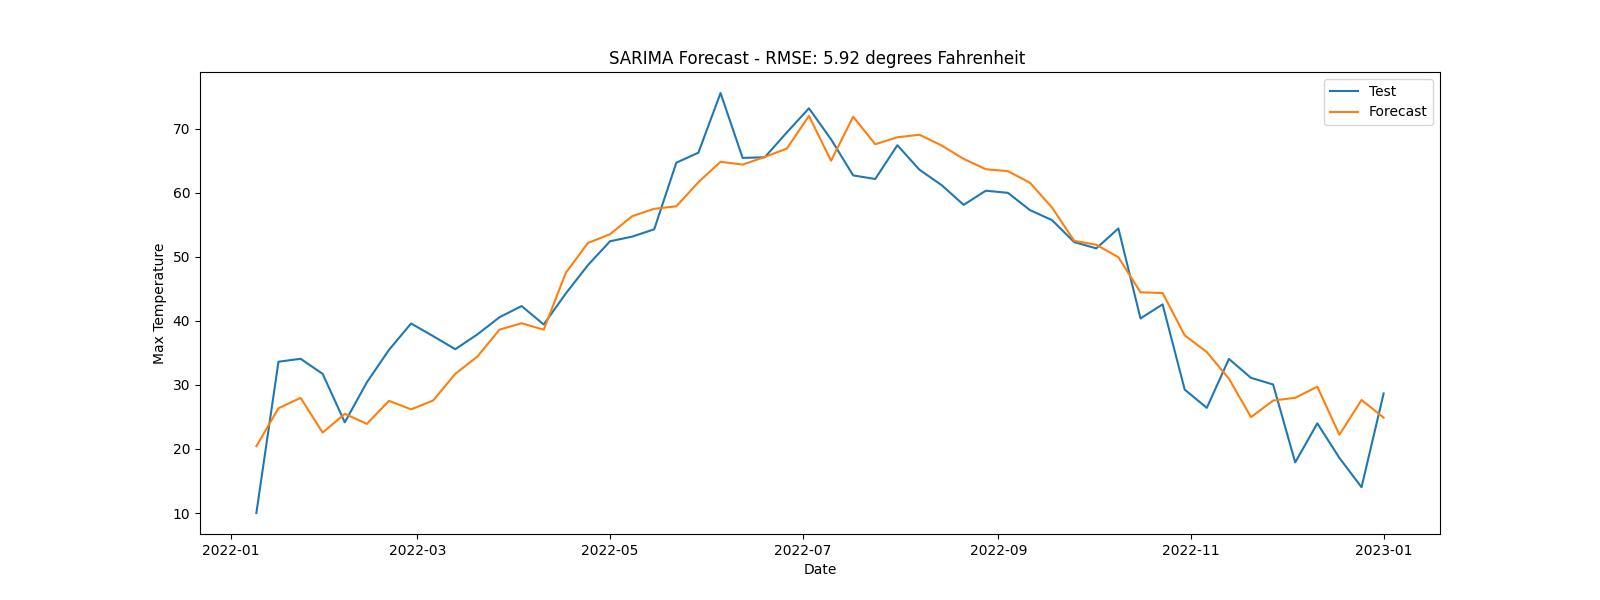

The grid test defintely gave us better results. The AIC is lower and the AR and MA coefficients are significant. But we are still gaving problems with the Jarque-Bera test. Lets take a look at the residuals to see how non normal they really are.

## Residuals

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy.stats import jarque_bera
from _9_fit_sarima_original_anchorage import best_model_refit

In [ ]:
# Get the residuals
model = best_model_refit_ex
residuals = model.resid

# Calculate mean and variance, Jarque-Bera Test for Normality
mean_residual = np.mean(residuals)
variance_residual = np.var(residuals)
jb_stat, jb_pvalue = jarque_bera(residuals)

print(f"Mean of Residuals: {mean_residual}")
print(f"Variance of Residuals: {variance_residual}")
print(f"Jarque-Bera statistic: {jb_stat}")
print(f"Jarque-Bera p-value: {jb_pvalue}")


# Plot the residuals
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals.index, residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--', label='Zero Line')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Time Series of Residuals')
plt.legend()

# Plot histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
Mean of Residuals: 0.11489103504219199
Variance of Residuals: 45.18002939698132
Jarque-Bera statistic: 90.97920010685247
Jarque-Bera p-value: 0.0

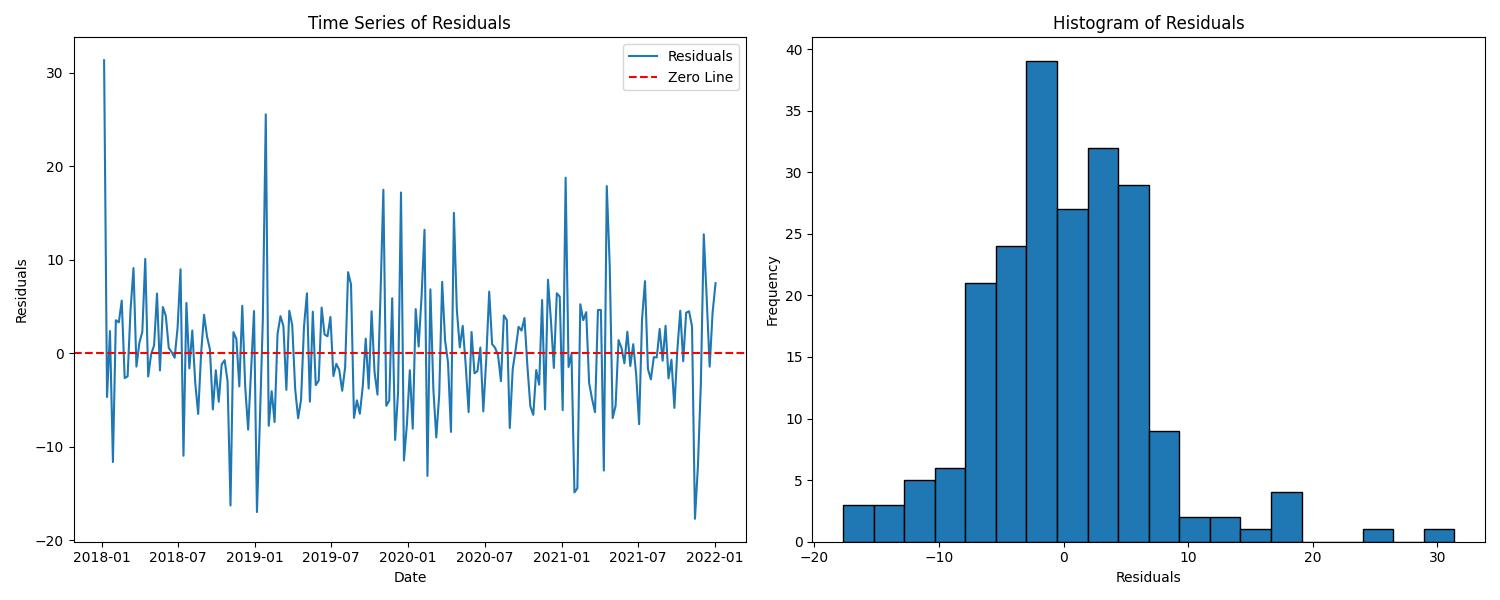

The residuals over time don't show any obvious pattern, which is good as it suggests that the model is capturing the underlying process well, leaving behind noise. However, the histogram does not exhibit a fully normal distribution. It is right skewed from two values, which could be outliers or the model not being complex enough to capture the underlying process. Since there are more large positive residuals, the model's predictions will be consistently lower than the actual observed values for those data points. At this point, I am going to try another model to see if it works better than SARIMA.